# Neural Network

This is a neural network from the lecture series by Andrej Karpathy.

## NN

- This series implements an autograd engine, i.e., automatic gradient computation.

- Essentially, this represents backpropagation, the algorithm which efficiently computes the gradients of a loss function relative to its weights. At its core, backpropagation recursively applies the chain rule on local derivatives, starting from the loss function. The aim is to iteratively tune the weights to minimize the loss function.

- Backpropagation is "just" a recursive, backward multiplication of local derivatives.

- What we seek in training the network is the derivative of the loss function with respect to all its weights. This derivative indicates the direction and extent of change in the loss if we marginally increase a weight.

- Micrograd teaches the fundamental principles of NN. Most other aspects surrounding NNs are related to efficiency improvements. For example, tensors enable parallel computations.



In [61]:
# Load libraries
import math
import numpy as np      
import matplotlib.pyplot as plt
import random
%matplotlib inline

import torch

# Graph API
from graphviz import Digraph

## Derivatives




### Numerical Example 1

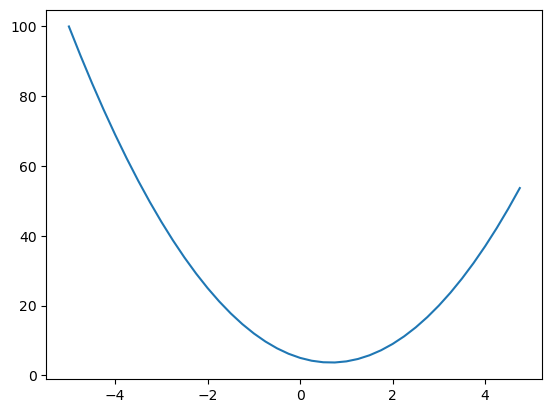

In [2]:
# Given the parabolic function
def f(x):
    return 3*x**2 -4*x + 5

xs = np.arange(-5, 5, .25)
ys = f(xs)
plt.plot(xs, ys)

*What does the derivate tells us?*

A derivative can be approximated by the following fornula:

$\frac{f(a+h) - f(a)}{h}$

Intuition: if you marginally increase $f(a)$ by $h$ what the derivative gives us is the relative change of the function. The division by $h$ normalises the change in the output of the function. We can follow the rules learned in calculus, or the above formula for a tiny $h$.

Below we apply the formula for the function at $x=3$:

In [3]:
# Small h and value for x
h =.001
x = 3.0

(f(x+h) - f(x))/h

14.00300000000243

The result gives us the slope of the function at $x=3$, which indicates that a marginal push of the function at this value changes the ouput of the function positively. To be precise, the slope is the rate with which the function changes if we nudge it by $h$.

### Numerical Example 2

In [4]:
# Define h and other scarlars
h =.0001

a=2.0
b=-3.0
c=10.0

d1 =a*b+c
a+=h
d2 =a*b+c

print("d1", d1)
print("d2", d2)
print("slope", (d2-d1) / h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


__Intuition__: d2 will be smaller than d1 as we multiply a larger $a$ with a negative $b$. Hence, we expect the derivative for this bump to be negative.

So far we have computed the derivative for multiplications. We now do so for additions:

In [5]:
# Set h and scalars for an addition
h =.0001

a=2.0
b=-3.0
c=10.0

d1 =a*b+c
c+=h
d2 =a*b+c

print("d1", d1)
print("d2", d2)
print("slope", (d2-d1) / h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


__Intuition__: the slope is one, which indicates that if we increase the constant by $h$, the change in the function will be exaclty $h$, as we just add $h$ to $c$, the constant. The function increases by the amount we add, the slope is hence 1.

Next we build a data class for performing and holding specific values.

## Data Class

This builds a class `Value` with which we can build the neural net and perform all required computations. Furthermore, the class allows understanding how each value comes about, that is, it provides the scalars, operations, and pointers that lead to each scalar.

Everything should be intuitive, but the more complex concepts are:

- Children: For every operation, we also add the children of the new value that is created. When we create a new value, say $d$ from multiplying $a$ with $b$, then $d$'s children are $a$ and $b$.

- Gradient: The gradient is the effect of a change in a value (a weight) on the loss. It is a vector storing all the partial derivatives of a function.

- Backward: Each instantiation of the class has an attribute `_backward`. This is a function returning `None` by default. The function is used to propagate the gradient from the instantiation of the class to its children. Depending on the operation, either addition or multiplication, the function in the attribute changes, which is implemented in the respective function for either addition or multiplication. Calling this function on an object computes the gradients of its children. For leaf nodes, this function will always remain none, as there are no gradients to further propagate.

The below code is taken from the lecture. It is shows the DAG of a numerical expression, and serves for visualisation only.

In [6]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [134]:
# Mine
class Value:
    def __init__(self, data, _children=(), _op='', label=''): 
        '''Initializes the value'''
        self.data = data
        self.grad=0.0 # Initialising at 0 means the value has initially no effect on the final output
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self._backward = lambda: None # Basic case, won't change for leaf nodes

    def __repr__(self) -> str:
        '''Returns a string representation of the value'''
        return f"Value({self.data})" 

    def __add__(self, other):
        '''Adds two values and creates a new value'''

        # Allowing adding a number to a value object
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        # Define _backward for an addition
        def _backward():
            '''Propagates out's grad into self's and other's grad'''
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        
        # Assigns the add function to the value's backward attribute
        out._backward = _backward

        return out
    
    def __mul__(self, other):
        '''Multiplies two values and creates a new value'''

        # Allowing adding a number to a value object
        other = other if isinstance(other, Value) else Value(other)        
        out = Value(self.data * other.data, (self, other), '*')
    
        def _backward():
            self.grad +=other.data*out.grad # (local derivative * gradient from parent)
            other.grad +=self.data*out.grad

        out._backward = _backward

        return out
    
    def __pow__(self, other: int or float):
        
        # Supporting int/float only
        assert isinstance(other, (int, float)), "only int/float for exponent"

        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other*(self.data**(other-1))*out.grad
             

        out._backward = _backward

        return out

    def __rmul__(self, other):
        '''Will be called if __mul__ is called on an integer.
        Reverses the order of object and int to match the __mul__ function'''
        return self * other

    def __truediv__(self, other):
        return self*other**(-1) # Exploits above mutlipl. and pow.

    def __neg__(self):
        return self*-1 # Exploits above multiplication
    
    def __sub__(self, other):
        return self + (-other) # Exploits above multiplication and addition

    def __radd__(self, other): # other + self
        return self + other

    def tanh(self):
        ''''Returns the tanh value for the stored data'''
        n = self.data
        t = (math.exp(2*n) - 1)/(math.exp(2*n) + 1)
        out = Value(t, (self,), 'tanh') # Just one child, as tanh takes the scalar of the neuron

        def _backward():
            '''Implements the backprop function for a tanh object.'''
            self.grad += (1-out.data**2) * (out.grad) # local derivative of tanh*derivative of the output

        # Assigns the tanh function to the _backward attribute of the object
        out._backward = _backward
        return out

    def exp(self):
        x=self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out  
    
    def backward(self):

        '''Implements the entire backprop from the root node.
        topo is a topological sort, that linearises a DAG
        '''
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child) # recurisve call finds all the children of the root
                topo.append(v)

        build_topo(self)
        self.grad=1.0 # As the default of value of an object is 0
        for node in reversed(topo): # In reverse, as the last node is last in the list
            node._backward()
        


In [9]:
a= Value(3.0)
b= Value(3.0)
print(a**3)

print(a/b)

Value(27.0)
Value(1.0)


Repeating the second numeric example from above with the value class:

In [10]:
# Instantiate values, also computes intermediary steps
a=Value(2.0, label='a')
b=Value(-3.0, label='b')
c =Value(10.0, label='c')
e=a*b
e.label = 'e'
d=e+c
d.label = 'd'

f = Value(-2.0, label='f')

# Final output (loss)
L= d * f
L.label='L'

print("d is", d)

# The children of d are
print("d's children are: ", d._prev)
print("d's operation is: ", d._op)

d is Value(4.0)
d's children are:  {Value(10.0), Value(-6.0)}
d's operation is:  +


We can now visualise $d$ and its dependencies, that is, it consists of the mutliplication of $a$ and $b$ (as one scalar) and the constant $c$.

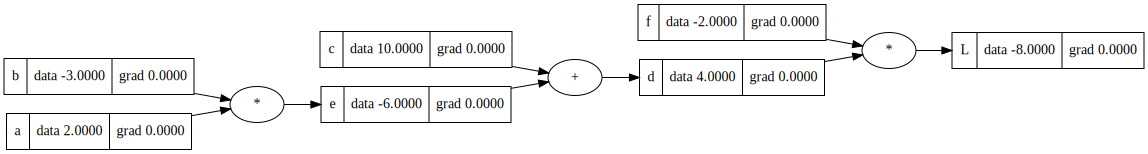

In [11]:
draw_dot(L)


**Forward pass**

This mathematical expression is an example of a forward pass. We have three inputs $a$, $b$, $c$, and $f$, which produce a single output, $L$.

**Backward pass**
 The crux of a neural network is the backpropagation. The below performs manual backprop for the mathematical expression above. I will compute the gradient for each scalar manually.

## Backpropagation

### Manual Backprop 1: Calculating gradients manually

**A. Gradient of the loss function**

_What is the gradient of L?_

In other words, how does $L$ change, if we change $L$ by itself? Intuitively, the derivative has to be 1. We can show this with the function below, which nudeges $L$ by $h$, and uses the above formula for derivatives to compute the gradient.

In [12]:
# 1. Gradient of L
def manual_derivative_L():

    h=.001

    a=Value(2.0, label='a')
    b=Value(-3.0, label='b')
    c =Value(10.0, label='c')
    e=a*b
    e.label = 'e'
    d=e+c
    d.label = 'd'

    f = Value(-2.0, label='f')

    L= d * f
    L.label='L'
    
    L1 = L.data
    L2 = L.data + h    

    print('Gradient for L: ', (L2 - L1) / h)

manual_derivative_L()

# Hence
L.grad = 1.0 # because changing L by h will change L by h


Gradient for L:  1.000000000000334


**B: Gradients of d and f**

What we need is $dL/dd$ an $dL/df$ which can be computed easily as both are directly connected to $L$. 

For $d$, for example, we can show that $dL/dd = f$ using the above formula for derivates: 

1. $((d+h) * f) - (d * f)) / h$
2. $(fd * hf - df) / h$
3. $hf/h$
4. $f$

By symmetry, the same applies to $d$.

We can verify this by nudging $d$ marginally by $h$.

In [13]:
# 2. Gradient of d and f
# Due to symmetry, I calculate the gradient for d only
def manual_derivative_f_d():

    h=.001

    a=Value(2.0, label='a')
    b=Value(-3.0, label='b')
    c =Value(10.0, label='c')
    e=a*b
    e.label = 'e'
    d=e+c
    d.label = 'd'

    f = Value(-2.0, label='f')

    L= d * f
    L.label='L'
    
    L1 = d.data * f.data
    L2 = (d.data + h) * f.data

    print('Gradient d: ', (L2 - L1) / h)

manual_derivative_f_d()


# Hence
d.grad = -2 # L = d*f, so dL/dd = f
f.grad = 4 # L = d*f, so dL/df = d

Gradient d:  -2.000000000000668


**C: Gradients of c and e**

Up until now, we have a direct connection between a value and the loss, $L$. We now deal with $e$ and $c$, which are indirectly influencing $L$, i.e., not directly as $d$. 

What we need is the effect of both $e$ and $c$ on $L$. For $c$ we need: 

$$\frac{dL}{dc}$$

**Chain Rule**

We exploit the chain rule for backpropagation. The effect of $c$ on $L$ goes through $d$. Intuitively, we first want the effect of $c$ on $d$, and second, the effect of $d$ on $L$. We chain both effects together via multiplication (see an intuitive example on the Wikipedia page of the chain rule).

$$\frac{dL}{dc} = \frac{dL}{dd} \times \frac{dd}{dc}$$

$\frac{dd}{dc} = 1$ (local derivative)
$\frac{dL}{dd} = -2$ (parent's gradient)

Thus, the gradient for $c$ is -2. This can also be proven using the derivative formula as above.

**Note 1: Gradient vs Local Derivative**

Note that the local derivative here is just $\frac{dd}{dc}$. However, this is not the effect on $L$. This is the information that the gradient possesses. The gradient, for a given value, is the local derivative times the gradient from the parent.

**Note 2: Addition**

An addition of a value smoothly propagates the gradient of the parent, as the derivative of the value in an addition is 1. It just passes it through the network.

---

We can confirm the above gradient for $c$ with our numeric example:


In [14]:
# 3. Gradient of c and e
# Due to symmetry, I calculate the gradient for c only
def manual_derivative_c_e():

    h=.001

    # L1
    a=Value(2.0, label='a')
    b=Value(-3.0, label='b')
    c =Value(10.0, label='c')
    e=a*b
    e.label = 'e'
    d=e+c
    d.label = 'd'

    f = Value(-2.0, label='f')

    L1= d * f
    L1.label='L'
    
    # L2
    a=Value(2.0, label='a')
    b=Value(-3.0, label='b')
    c =Value(10.0 + h, label='c')
    e=a*b
    e.label = 'e'
    d=e+c
    d.label = 'd'

    f = Value(-2.0, label='f')

    L2= d * f
    L2.label='L'

    print('Gradient c: ', (L2.data - L1.data) / h)

manual_derivative_c_e()


# Hence
c.grad=-2 
e.grad=-2 # by symmetry


Gradient c:  -1.9999999999988916


**D: Gradients of a and b**

What we need is $\frac{dL}{da}$. Again, we exploit the chain rule to chain the local derivative with the gradient from the parent. This is:

$$\frac{dL}{da} = \frac{de}{da} \times \frac{dL}{de}$$ 

or, when we chain all local derivatives:

$$\frac{dL}{da} = \frac{de}{da} \times \frac{dd}{de} \times \frac{dL}{dd}$$

The local derivative of $e$ with respect to $a$ is $b$, as this is a multiplication. The parent gradient is -2.

Hence, $\frac{dL}{da} = -3 \times -2 = 6$.




In [15]:
# 4. Gradient of a and b
# Due to symmetry, I calculate the gradient for c only
def manual_derivative_a_b():

    h=.001

    # L1
    a=Value(2.0, label='a')
    b=Value(-3.0, label='b')
    c =Value(10.0, label='c')
    e=a*b
    e.label = 'e'
    d=e+c
    d.label = 'd'

    f = Value(-2.0, label='f')

    L1= d * f
    L1.label='L'
    
    # L2
    a=Value(2.0 + h, label='a')
    b=Value(-3.0, label='b')
    c =Value(10.0, label='c')
    e=a*b
    e.label = 'e'
    d=e+c
    d.label = 'd'

    f = Value(-2.0, label='f')

    L2= d * f
    L2.label='L'

    print('Gradient a: ', (L2.data - L1.data) / h)

manual_derivative_a_b()


# Hence
a.grad=6
b.grad=-4 # by symmetry


Gradient a:  6.000000000000227


This is backpropagation.

We have control over the weights in the neural network, which are leaf nodes. In the numerical example, these are the values $a$, $b$, $c$, and $f$, which can be changed. If we want to minimize $L$, we have to change those values by their gradient, times a step size, i.e., the learning rate.

To exemplify this, we can perform a single optimization step below:


In [16]:
# Learning rate (note that this is negative in a NN, here it is negative as we aim to maximise L)
alpha=.01
a.data+=alpha*a.grad
b.data+=alpha*b.grad
c.data+=alpha*c.grad
f.data+=alpha*f.grad

# After the first optimization step, we can run another forward pass
d=a*b+c
L= d * f

print('Loss after one optimisation step ', L.data)

Loss after one optimisation step  -7.286496


Our loss is reduced from -8 to the new loss above.

### Manual Backprop 2: Neuron

We now perform manual backpropagation, not on the mathematical example from above but on a neuron as we will find it in neural networks. A single neuron is a summed multiplication of weights and inputs plus a bias. The resulting scalar is inputted into an activation function, which introduces the non-linearity of the network.

- Bias provides the trigger sensitivity. This is a scalar that can be adjusted instead of adjusting the weights.

**Note: Differentiability**

For any function in the network, whether it be a simple addition or the activation function, what is essential is that we know the derivative of this function to perform backpropagation. Functions can be super simple or complex; what matters is that they are differentiable so that we can compute the local derivative.


In [17]:
# Initialise inputs, weights, bias, and activation function
x1=Value(2.0, label='x1')
x2=Value(0.0, label='x2')

w1=Value(-3.0, label='w1')
w2=Value(1.0, label='w2')

b=Value(6.8813735870195432, label='b') # So that the gradients are nice numbers

# Perform intermediary steps, to create the full plot with pointers
w1x1=w1*x1
w1x1.label = 'w1*x1'

w2x2=w2*x2
w2x2.label = 'w1*x1'

w1x1w2x2= w1x1 + w2x2
w1x1w2x2.label = 'w1x1 + w2x2'
n=w1x1w2x2+b
n.label='n'

# Activiation function
o=n.tanh()
o.label = 'o'

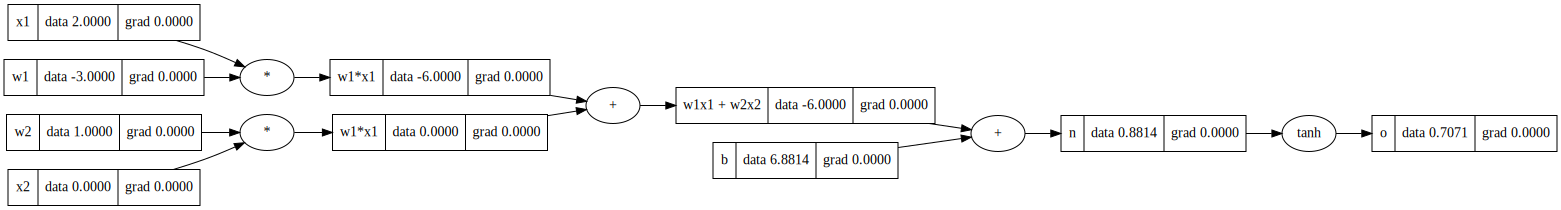

In [18]:
draw_dot(o)

Given we have built the neuron, saved it, and can visualise it, we can now perform the manual backprop of the neuron.

**A: Gradient of o (activation)**

The base case is the derivative of $o$ with respect to itself. This is, again, just 1.


In [19]:
# Set the gradient of o to 1
o.grad=1.0

**B: Gradient of n (neuron)**

What we need is $\frac{do}{dn}$, that is the derivative of $\tanh$ with respect to its input, $n$ (the neuron).

The derivative of $\tanh$ is $1 - (\tanh(n)^2)$ where $\tanh$ of $n$ is $o$ in our case.

In [20]:
# Gradient of o with respect to n
o.grad = 1 - o.data**2

**C: Gradients of w1x1w2x2 and b, and x2w2 and x1w1**

The gradient of both expressions $w1x1w2x2$ and $b$ is the local derivative of the expression times the gradient of $o$. The local derivatives are 1 in both cases as this is an addition. The sum routes the gradient of $o$.

For the bias, we need $\frac{dn}{db}$. This is

$$\frac{do}{db} = \frac{dn}{db} \times \frac{do}{dn}$$

The exact same logic applies to all other scalars, as all come about by an addition.

In [21]:
# Gradients for b and the sum of weights and the bias
b.grad = 1.0*o.grad
w1x1w2x2.grad = 1.0*o.grad

# Gradients for x1w1 and x2w2
w1x1.grad = 1.0*w1x1w2x2.grad
w2x2.grad = 1.0*w1x1w2x2.grad

**Note: Gradient**

As an intuition check for the gradient: if we want the value of the neuron to **increase**, then the gradient tells us in which direction we have to adjust the scalar. The gradient is a rate, though, so it does not say that the output will change by the gradient itself! It gives us the relative rate at which the output changes when we increase the scalar marginally.


**C: Gradients of w1, x1, w2, x2**

Here we encounter a multiplication.

For \( w1 \) for example, we need \(\frac{do}{dw1}\) which is 

$$\frac{do}{dw1} = \frac{dw1x1}{dw1} \times \frac{do}{dw1x1}$$


In [22]:
# For w1, for example, we multiply the gradient of w1x1 with the local derivative
w1.grad =x1.data*w1x1.grad

# By symmetry, for the others we follow the same logic
x1.grad = w1.data*w1x1.grad
w2.grad = x2.data*w2x2.grad
x2.grad = w2.data*w2x2.grad


Now that we have completed the entire backpropagation for this neuron, we can implement the backpropagation functions for each operation in the Value class.

The idea in the implementation is that each Value object has a specific backward function, depending on its operation. We have a basic `_backward` that does nothing, and it won't do anything for leaf nodes. When we create a new value, then the backward function will be defined according to the operation.


### Manual Backprop 3: backward functions for each object

Now, having implemented the backpropagation functions (see Value class), we can call the functions for each operation.

We begin by setting the gradients to 0, except for the output's gradient. (copy-pasted the code from above)

In [23]:
# Re-instantiate the sclars

# Initialise inputs, weights, bias, and activation function
x1=Value(2.0, label='x1')
x2=Value(0.0, label='x2')

w1=Value(-3.0, label='w1')
w2=Value(1.0, label='w2')

b=Value(6.8813735870195432, label='b') # So that the gradients are nice numbers

# Perform intermediary steps, to create the full plot with pointers
w1x1=w1*x1
w1x1.label = 'w1*x1'

w2x2=w2*x2
w2x2.label = 'w2*x2'

w1x1w2x2= w1x1 + w2x2
w1x1w2x2.label = 'w1x1 + w2x2'
n=w1x1w2x2+b
n.label='n'

# Activiation function
o=n.tanh()
o.label = 'o'

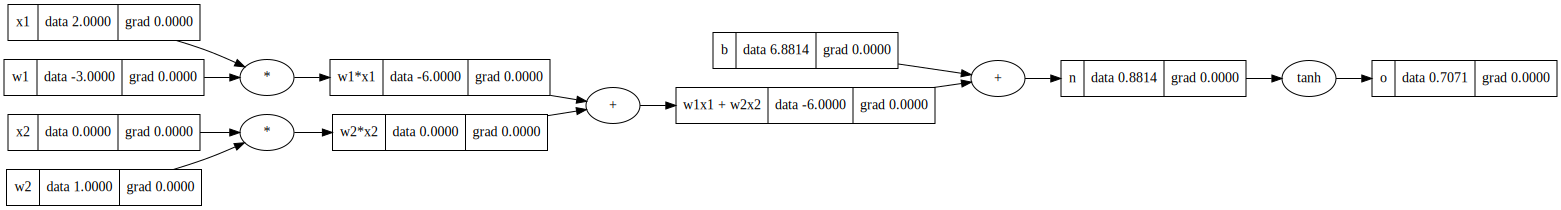

In [24]:
draw_dot(o)

We have the `_backward` operation type and for each scalar. We thus have to call them in the right order beginning fro the root.

In [25]:
# Initialise the grad of o to 1, otherwise there won't be any updates
o.grad=1.0 # Default of value object is 0

# Call backward in the right order
o._backward()
n._backward()
w1x1w2x2._backward()
b._backward() # Just to see whether the base case is working 

# Backaward for the leaf notes x and w
w1x1._backward()
w2x2._backward()


This yields the same gradients as the manual calculation. However, we do not want to manually call the function each time. 

We can instead implement a topological sort.

- Topological sort: arranges a graph so that all its nodes go from left to right. In other words, it linearizes a Directed Acyclic Graph (DAG).

- The idea of the below implementation is that the sort starts at the root, $o$, and adds all the dependent children to a list. The recursive call ensures that the root is added last, and all the children are added before, which builds the linearity.

In [26]:
# This is a recursive implementation of topo
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
    for child in v._prev:
        build_topo(child)
    topo.append(v)

# Build topo from the root node
build_topo(o)
topo


[Value(1.0),
 Value(0.0),
 Value(0.0),
 Value(2.0),
 Value(-3.0),
 Value(-6.0),
 Value(-6.0),
 Value(6.881373587019543),
 Value(0.8813735870195432),
 Value(0.7071067811865476)]

Given that we now have the linear order of the nodes, we can call `backward` in reverse order. Reverse because the last node in the list is also the last element.

Executing the below code gives us the same result as 1) the manual backpropagation and 2) calling the `backward` function at each node.


In [27]:
o.grad=1.0 # Default of value object is 0
for node in reversed(topo):
    node._backward()

o

Value(0.7071067811865476)

We can implement the topological order in the value class.

### Manual Backprop 3: backward called on the root only

In [28]:
# Re-instantiate the sclars

# Initialise inputs, weights, bias, and activation function
x1=Value(2.0, label='x1')
x2=Value(0.0, label='x2')

w1=Value(-3.0, label='w1')
w2=Value(1.0, label='w2')

b=Value(6.8813735870195432, label='b') # So that the gradients are nice numbers

# Perform intermediary steps, to create the full plot with pointers
w1x1=w1*x1
w1x1.label = 'w1*x1'

w2x2=w2*x2
w2x2.label = 'w2*x2'

w1x1w2x2= w1x1 + w2x2
w1x1w2x2.label = 'w1x1 + w2x2'
n=w1x1w2x2+b
n.label='n'

# Activiation function
o=n.tanh()
o.label = 'o'

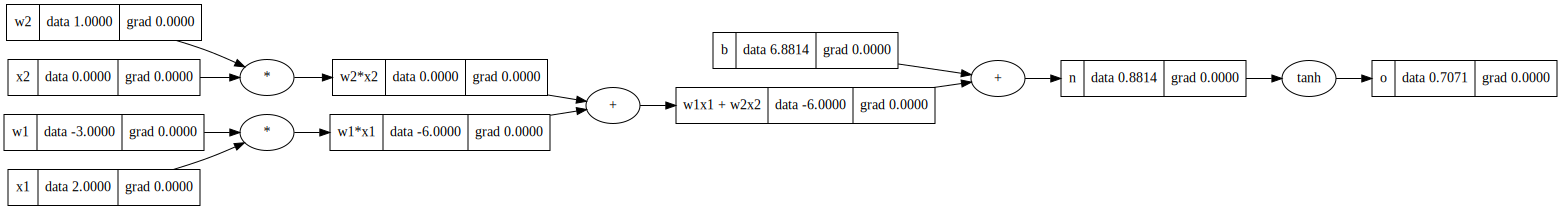

In [29]:
draw_dot(o)

In [30]:
# Call the backward function on the root
# Which, again, is one optimisaiton step
o.backward()

### Extra: Gradient Calculation

We now briefly explore why we accumulate gradients for a given node.

For the below example, $a$ is a component of $c$ and $d$. If we make the the gradient of $a$ depending on the latest connection only, we would overwrite its gradient. For example, if $a$'s gradient is last influenced by $c$, it becomes -6. But this ignores the information from $d$. To address this, we add the gradients of $a$ from all its dependecies. This solution is the multivariate case of the chain rule.

For $a$, the gradient is therefore

$$\frac{de}{da} = \frac{dd}{da} \times \frac{de}{dd} + \frac{dc}{da} \times \frac{de}{dc}$$

Which is 

$$\frac{de}{da} = 3 \times 1 + 1 \times -6 = -3$$



In [31]:
# Example where a single scalar is dependent on more than one other
# These are a and b
a = Value(-2.0, label='a')
b = Value(3.0, label='b')


c = a+b
c.label= 'c'
d = a*b
d.label= 'd'

e=c*d
e.label='e'


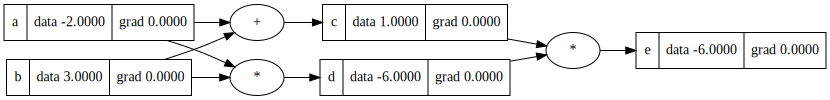

In [32]:
# Draw scalars
draw_dot(e)

In [33]:
# Compute gradient and check for a and b
e.backward()

### Extra: Breaking up tanh

So far, we have used a function for $tanh$ but we can also break this into its single parts. This is implemented below. $Tanh$ has the following formula:

$$tanh = \frac{e^{2x} - 1}{e^{2x} + 1}$$

This exercise implements new operations, such as exponentiation, division, and shows that backprop an be performed at the most singular operations/objects.


In [46]:
# Re-instantiate the sclars

# Initialise inputs, weights, bias, and activation function
x1=Value(2.0, label='x1')
x2=Value(0.0, label='x2')

w1=Value(-3.0, label='w1')
w2=Value(1.0, label='w2')

b=Value(6.8813735870195432, label='b') # So that the gradients are nice numbers

# Perform intermediary steps, to create the full plot with pointers
w1x1=w1*x1
w1x1.label = 'w1*x1'

w2x2=w2*x2
w2x2.label = 'w2*x2'

w1x1w2x2= w1x1 + w2x2
w1x1w2x2.label = 'w1x1 + w2x2'
n=w1x1w2x2+b
n.label='n'

# Activiation function
# Code here changes, instead of calling the function we implement it manually
# o=n.tanh()
e = (2*n).exp()

o = (e - 1) / (e + 1)
o.label = 'o'

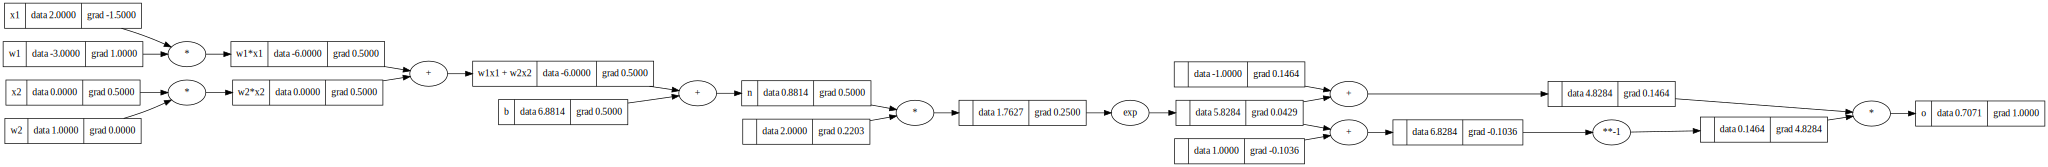

In [47]:
# Compute gradients and draw graph
o.backward()
draw_dot(o)

## PyTorch

Now we implemented the above manual coding of Value objects and backprop in PyTorch. In PyTorch, everything is based on `tensors` that are n-dimensional arrays.

We implenet the above neuron now in PyTorch. There are two additional steps in this framework:

1. We need to define the value of the tensor as a `double` to

2. We need to manuallt define that a tensor possessess a gradient. PyTorch assumes by default that leaf nodes have no gradient.


In [59]:
# Load torch
import torch

# Define tensors, here, one-dim. tensors
x1 = torch.Tensor([2.0]).double()
x2 = torch.Tensor([0.0]).double()
w1 = torch.Tensor([-3.0]).double()
w2 = torch.Tensor([1.0]).double()
b= torch.Tensor([6.8813735870195432]).double()

# Assign them a gradient
x1.requires_grad = True
x2.requires_grad = True
w1.requires_grad = True
w2.requires_grad = True
b.requires_grad = True

# Build neuron
n = w1*x1 + w2*x2 + b

# Activation function
o = torch.tanh(n)

The above is the forward pass. To perform backprop, we can call the `backward` function in the same fashion as implemented in the Value class.

_Q: why can't I perform backprop a second time? Why does PyTorch assumes by default no gradients for leaf nodes (it is them that need them)?_

In [60]:
# Perform backprop
o.backward()

# Show results
print('o ', o.data.item())
print('w1 ', w1.grad.item())
print('w2 ', w2.grad.item())
print('x1 ', x1.grad.item())
print('x2 ', x2.grad.item())

o  0.7071066904050358
w1  1.0000002567688737
w2  0.0
x1  -1.5000003851533106
x2  0.5000001283844369


## Building a Neural Network

Now we build a neural network with the Value class, which resembles the way we would implement a NN in PyTorch, as we have seen above.

__ADD DESCRIPTIONS HERE__

_Why do all neurons in the same layer get the same input?_

_Why can't we use the gradients of the input data as  measure of feture importance?_

In [196]:
class Neuron:

    def __init__(self, nin): # nin=number of inputs into this neuron
        self.w=[Value(random.uniform(-1, 1)) for _ in range(nin)] # we need the same number of weights
        self.b=Value(random.uniform(-1, 1)) # and one bias term (captures overall trigger happines)

    # call function is n(x)
    def __call__(self, x): # x input list to the neuron
        # Neuron = dot product + bias = w * x + b
        n = sum((w * x for w, x in zip(self.w, x)), self.b) # Second argument is the vale to start with (this is just for efficiency)
        out = n.tanh()
        return out
    
    def parameters(self):
        '''Returns a list of parameters for this neuron'''
        return self.w + [self.b]
    
class Layer():
    '''
    
    @nin: defines the number if inputs for each neuron in this layer
    @noun: defines the number neurons in this layer, and thus the number outputs
    '''
    def __init__(self, nin, noun): # nout = number of neurons in this layer
        self.neurons = [Neuron(nin) for _ in range(noun)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons] # all neurons get the same input
        return outs[0] if len(outs)==1 else outs
    
    def parameters(self):
        return  [p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP():

    def __init__(self, nin, nouts: []):
        # Get list of sizes for each layer.
        sz = [nin] + nouts
        # Define Layer. Logic: output of i is the input of i+1
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)

        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [206]:
# Initialise the MLP
random.seed(42)
mlp = MLP(3, [4, 4, 1])
mlp([2.0, 1.0, 4.0])

Value(0.48054101857832143)

Now we feed some data into the MLP, that is, the first forward pass.

In [207]:
# Inouts data 4 observations with three features each
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]

# Outputs
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [201]:
# Predictions from the nlp
ypred = [mlp(x) for x in xs]
ypred

[Value(0.6994093620224068),
 Value(0.5026295816615511),
 Value(0.6931545900944501),
 Value(0.8755224728708613)]

We see that for the given x variables, the network outputs the above values for the four examples.The entire goal of a NN is to make the predictions closer to the true labels by updating its weights. The idea in deep learning is to summarise the model's performance in a single metric called the _loss_ which calculates the deviation from the predicion and the true labels. The goal is to minimise the loss function.

- Update Weights: The gradient gives the direction of the steepest ascent. As we want to minimse the loss, we need to multiply the gradient times $-1$. The gradient vector of the loss fucntion is a vector that points into the direction of the steepest ascent, it is a vector that collects all the partial derivatives.

In [202]:
# This implements the mean squared error loss
# Here we sum but usually the mean is taken
loss = sum([(pred - tr)**2 for tr, pred in zip(ys, ypred)])
loss

Value(5.230517512042234)

Now to see how backpropagation works we do the following.

1. Feedfoward
2. Compute loss
3. Compute gradients via backpropagation
4. Update gradients
5. Feedforward with updated weights

We have done 1. and 2. above. After having updated the gradients, we expect the loss to shrink for the next predictions.

In [203]:
# 3. Compute gradients by calling the backward function
loss.backward()

# 4. We update gradients as described above
for p in mlp.parameters():
    p.data += -.001*p.grad

# 5. Feedforward with updated gradients
ypred = [mlp(x) for x in xs]
loss = sum([(pred - tr)**2 for tr, pred in zip(ys, ypred)])
loss

Value(5.163772018584386)

The loss is, as expected, descreased. Now we want to perform multiple optimisation steps, that is, we want to reduce the loss across various iterations on the data.

__Backpropagation Training Loop__

We now perform the full training of the network. The optimisation process is as follows:

1. Forwad pass: takes input, compute the loss

2. Backpropagation: based on the loss, use backprop to compute gradients of weights

3. Update: weights by a learning rate times their gradients

4. Do not forget to set gradients to 0 after the updating. Otherwise, we would accumulate the gradient across backprops.

$<repeat>$

In [208]:
for e in range(20):

    # Feedforward
    ypred = [mlp(x) for x in xs]
    # Compute loss
    loss = sum([(pred - tr)**2 for tr, pred in zip(ys, ypred)])

    # Backprop
    for p in mlp.parameters():
        p.grad = 0.0
    loss.backward()

    # Update weights
    for p in mlp.parameters():
        p.data += -0.05*p.grad

    print('Epoch ', e, 'loss ', loss)


Epoch  0 loss  Value(5.230517512042234)
Epoch  1 loss  Value(2.704689050764245)
Epoch  2 loss  Value(1.8460237252314982)
Epoch  3 loss  Value(1.1774870087919076)
Epoch  4 loss  Value(0.8217294550832634)
Epoch  5 loss  Value(0.595721558769391)
Epoch  6 loss  Value(0.43115794091632775)
Epoch  7 loss  Value(0.3468314917603137)
Epoch  8 loss  Value(0.28903713992681357)
Epoch  9 loss  Value(0.24605065583938196)
Epoch  10 loss  Value(0.21309389813936686)
Epoch  11 loss  Value(0.18718814718937854)
Epoch  12 loss  Value(0.16638755353165724)
Epoch  13 loss  Value(0.149379973370315)
Epoch  14 loss  Value(0.1352548466184191)
Epoch  15 loss  Value(0.12336389545940173)
Epoch  16 loss  Value(0.11323493741060485)
Epoch  17 loss  Value(0.1045170091877125)
Epoch  18 loss  Value(0.09694449026136838)
Epoch  19 loss  Value(0.09031307448189843)


Final output of the network and parameters:

In [209]:
# Ouput the number of paramters and the params themeselves
print(len(mlp.parameters()))
print(mlp.parameters())

# Final predictions
print(ypred)

41
[Value(0.3478717147547948), Value(-0.9764433565111943), Value(-0.3589156765408359), Value(-0.5098655563447688), Value(0.3592841843461595), Value(0.02252605395369802), Value(1.363600702499743), Value(-0.667796486343283), Value(-0.3990037747956722), Value(-0.8573116698364288), Value(-0.689920679349929), Value(-0.0852489590430916), Value(-0.9831208662196262), Value(-0.682349067751429), Value(0.21059385598656707), Value(0.010392145851499387), Value(-0.5778326994694057), Value(0.03959742761248725), Value(0.6814038989481905), Value(-0.9170591312656297), Value(0.5070080530937319), Value(0.3387614379665012), Value(-0.524870089341064), Value(-0.6828231468483026), Value(0.8939236639072351), Value(-0.34639093923455877), Value(-0.7235499901235632), Value(-1.2875098518542505), Value(0.8543501446808123), Value(0.28116974516256954), Value(0.36975553156553453), Value(0.4343760142408172), Value(0.011246343908418681), Value(0.9571108020998015), Value(-0.22825132757117797), Value(0.07804270668952953),

We see that the model predictions are fairly close to the true labels. The network has succesfully learned the patter of the data.

## Summary

Other topics:

- Batching: In this example we only had for observations, so we could feedforward with all the data and compute the loss accordinlgy. This is computationally with larger datasets. Instead of the full data, a batch of typically size 16 or 32 is randomly chosen from the data and used for the forward pass and backpropagation.

- Regularisation: dropping/freezing parameters

- Learning rate decay